NLCD tiff already exists
IPSA tiff already exists
(527085.0, 30.0, 0.0, 4582215.0, 0.0, -30.0)


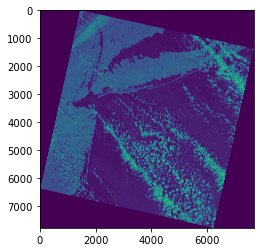

In [6]:
'''
Dandan Wei
Jan 14, 2022

This script crop the land cover and ISA into the NYC shape, using Landsat projection.
Input dataset:
        nlcd_2019_land_cover_l48_20210604.img
        nlcd_2019.tif
        NYC shapefile
        LC08_L1TP_013032_20220110_20220110_02_RT_refl.tiff (random)
Output dataset:
        nlcd_epsg32618_cropped.tif
        lsat_epsg32618_cropped.tif
        ipsa_epsg32618_cropped.tif
'''

import gdal, ogr, osr
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio

################################################################
#                                                              #
#                     User-defined functions                   #
#                                                              #
################################################################

def get_NYC_bbox(shapefile, target_EPSG):
    ''' 
    To get the bounding box of NYC
    '''   
    # define shapefile driver
    drv         = ogr.GetDriverByName('ESRI Shapefile') 
    ds_in       = drv.Open(shapefile,0) 
    lyr_in      = ds_in.GetLayer()            # grab layer
    sourceprj   = lyr_in.GetSpatialRef()      # source projection
    targetprj   = osr.SpatialReference()
    targetprj.ImportFromEPSG(target_EPSG)     # target projection
    transform   = osr.CoordinateTransformation(sourceprj, targetprj)

    shp         = lyr_in.GetExtent()
    ll_x,ll_y,_ = transform.TransformPoint(shp[0],shp[2]) # reprojected bounds for city
    ur_x,ur_y,_ = transform.TransformPoint(shp[1],shp[3]) # reprojected bounds for city
    bbox        = [ll_x, ll_y, ur_x, ur_y]    # bounding box
    # print("The original prj is :\n", sourceprj)
    # print("The target   prj is :\n", targetprj)
    print('NYC bbox :', bbox)
    return bbox    

def get_geotransform(raster_file_path):
    ''' 
    To print the GeoTransform of a raster file
    '''
    ds = gdal.Open(raster_file_path)
    gt = ds.GetGeoTransform()
    print(gt)
    return gt  

def get_rasterSize(raster_file_path):
    ''' 
    To print the GeoTransform of a raster file
    '''
    ds = rasterio.open(raster_file_path)
    wd = ds.width
    ht = ds.height
    print('Width :', wd, 'Height :', ht)
    return (wd, ht)


def plot_raster(raster_file_path):
    ''' 
    Plot the raster arrays to do a quick check
    '''
    ds  = rasterio.open(raster_file_path)
    [fig, ax] = plt.subplots(1)
    ax.imshow(ds.read(1))
    plt.show()
    # plt.savefig(FigDir_temp + 'Landsat_tiff.png')
    return fig
    
################################################################
#                                                              #
#               Define directories and filenames               #
#                                                              #
################################################################
DataDir     = "/data0/dwei/"
LsatDir     = "/data0/dwei/nlcd2019/"
NlcdDir     = "/data0/dwei/nlcd2019/"
ShpeDir     = "/data0/dwei/NYCshapefiles/"
FigDir_temp = "/data0/dwei/temp/"
nlcd_img    = "nlcd2019/nlcd_2019_land_cover_l48_20210604.img"
ipsa_img    = "nlcd_2019_impervious_l48_20210604.img"
nlcd_tif    = "nlcd_2019.tif"
ipsa_tif    = "ipsa_2019.tif"
lsat_tif    = "LC08_L1TP_013032_20220110_20220110_02_RT_refl.tiff"
NYCshapefile= 'geo_export_a8b5d138-820a-4931-8d11-fe8604ea5bd1.shp'

# Check if NLCD and IPSA GTiff files exist
if os.path.exists(NlcdDir+nlcd_tif):
    print("NLCD tiff already exists")
else:       
    gdal.Translate(NlcdDir+nlcd_tif, NlcdDir+nlcd_img, format = 'GTiff')

if os.path.exists(NlcdDir+ipsa_tif):
    print("IPSA tiff already exists")
else:       
    gdal.Translate(NlcdDir+ipsa_tif,  NlcdDir+ipsa_img, format = 'GTiff')

# Get geoinfo of the random Landsat file
get_geotransform(LsatDir+lsat_tif)
fig = plot_raster(LsatDir+lsat_tif)
fig.savefig(FigDir_temp+'Landsat_raw.png')

NYC bbox : [563086.4981809029, 4483346.578300821, 609468.3374729961, 4530140.279354534]
(563086.4981809029, 30.0, 0.0, 4530140.279354534, 0.0, -30.0)
(563086.4981809029, 30.0, 0.0, 4530140.279354534, 0.0, -30.0)
(563086.4981809029, 30.0, 0.0, 4530140.279354534, 0.0, -30.0)
Width : 1546 Height : 1560
Width : 1546 Height : 1560
Width : 1546 Height : 1560


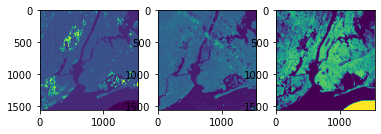

<Figure size 432x288 with 0 Axes>

In [8]:
#####################################################################
#                                                                   #
#   Crop NLCD, IPSA, and Lsat file to NYC in landsat CRS (32618)    #
#                                                                   #
#####################################################################

# Parameters  
target_xRes = 30.0
target_yRes = 30.0
target_EPSG = 32618    # Landsat projection
bbox = get_NYC_bbox(ShpeDir+NYCshapefile, target_EPSG) # NYC minx miny maxx maxy

# Crop the Landsat raster
output_lsat = LsatDir + 'lsat_epsg32618_cropped.tif'
gdal.Warp(output_lsat, \
          LsatDir+lsat_tif, \
          dstSRS = "EPSG:32618", \
          xRes = target_xRes, yRes = target_yRes, \
          outputBounds=bbox)  # outputBounds (minX, minY, maxX, maxY)

# Crop the NLCD raster
output_nlcd = DataDir + 'nlcd2019/nlcd_epsg32618_cropped.tif'
gdal.Warp(output_nlcd, \
          NlcdDir+nlcd_tif, \
          dstSRS = "EPSG:32618",\
          xRes   = target_xRes, yRes = target_yRes, \
          outputBounds=bbox) 

# Crop the IPSA raster
output_ipsa = DataDir + 'nlcd2019/ipsa_epsg32618_cropped.tif'
gdal.Warp(output_ipsa, \
          NlcdDir+ipsa_tif, \
          dstSRS = "EPSG:32618",\
          xRes   = target_xRes, yRes = target_yRes, \
          outputBounds=bbox) 

# Check if the two outputs match
get_geotransform(output_nlcd)
get_geotransform(output_lsat)
get_geotransform(output_ipsa)

get_rasterSize(output_nlcd)
get_rasterSize(output_lsat)
get_rasterSize(output_ipsa)

# Plot the two raster files
nlcd_cropped = rasterio.open(output_nlcd)
lsat_cropped = rasterio.open(output_lsat)
ipsa_cropped = rasterio.open(output_ipsa)

[fig, ax] = plt.subplots(1, 3)

ax[0].imshow(nlcd_cropped.read(1))
ax[1].imshow(lsat_cropped.read(1))
ax[2].imshow(ipsa_cropped.read(1))

plt.show()
plt.savefig(FigDir_temp + 'NLCD_IPSA_LSAT_cropped.png')